## TASKS:

### MAIN TARGET:

По каталогу: с добавленными полями, парсингом названий, состава, категорий, и т. д. уметь определять:
1. Это съедобно?
2. Это съедобно в сыром виде? (Ингридиент, готовое, и то и другое);
3. Какому продукту в каталоге нутриентов (например, по сайту frs24.ru) он соответствует?

### NAME TASK:

Повторять:
1. Посмотреть на список продуктов в "почищенном" варианте, найти проблемы;
2. Выписать список проблем;
3. Пофиксить.

### ANALYSIS TASK:

1. Распечатать пары категорий полученные здесь, и посмотреть как это выглядит - ✓
* однозначного ответа нет, как предполагалось. Некоторые подкатегории могут находиться в разных категориях, не нарушая при этом логику ("Леденцы" - "Витамины, БАДы" ("сладости"?)). Сказать, продукт в какой из категорий одназначно - нельзя, это зависит от составителя данных. Существуют группы, которые хорошо позволяют отличать съедобное от несъедобного ("Хлеб и выпечка", "Косметика"). Существуют группы, которые быстро позволяют определить тип товара на сырое или готовое ("Готовая еда"), но для некоторых товаров стоит также рассматривать подгруппы для точного анализа ("Замороженные овощи, грибы, ягоды и фрукты", "Овощи, фрукты, ягоды, зелень" => неготовое), некоторые подгруппы и группы не дают полного понимания о товаре, например: мульти группы, в таких случаях стоит обращать к названию товара ("Средства для стирки и мытья посуды", "Детское питание, гигиена и развитие"). Для более точного прогнозирования стоит использовать сразу несколько признаков (базовую группу, дочерную, название товара и т. д.), плохо, когда данных мало, и приходится работать с ужимкой, но и брать неподходящие данные незачем, что касается групп, то с ними можно работать;
2. Отобрать только те категории, которые есть у реальных продуктов из базы - ✓
* из 1610 категорий, осталось 1003, также исчезли все базовые категории имеющие пару NaN, что также облегчит работу;
3. Можно ли по этим данным разделить съедобные продукты от всех остальных - ✓
* не для всех групп, но в большинстве можно ("Готовые блюда", "Замороженные овощи", ...);
4. Какие ещё критерии можно использовать - ✓
* shop_id, если магазин специализированный, nutrion_value, как для съедобных продуктов, item_composition для крайне трудных случаев;
5. Какие дают самый полный результат - ✓
* расположем по порядку по полезности: nutrition, categories_array, item_name, item_composition, shop_id;
6. Найти библиотеку визуализации графов и представить связь категорий в подходящем для неё виде - ✓
7. Взять несколько продуктов с большим списком категорий и расшифровать их в название и название их корневой категории - ✓

## CODE:

### IMPORT MODULES:

In [1]:
import csv
import collections

import math as mh
import numpy as np
import pandas as pd
import string as st
import networkx as nx
import matplotlib.pyplot as plt

from time import time
from itertools import chain
from itertools import islice

### READ CSVS:

In [2]:
with open("../data/vkusvill_items.csv", 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    catalog_df = pd.DataFrame(reader)

catalog_df = catalog_df.rename(columns = {"": "shop_id", "item_composition_txt": "item_composition", "nutrion_value_txt" : "nutrion_value"})

In [3]:
categories_df = pd.read_csv("../data/vkusvill_categories.csv")
categories_df = categories_df.rename( columns = {"Unnamed: 0": "shop_id"})

### CHECK DATA FRAMES:

In [4]:
catalog_df

,shop_id,item_id,vat,price,measure_unit,measure_value,measure_quantum,categories_array,item_name,item_composition,nutrion_value,protein_value,fat_value,carb_value,energy_value
0,0,38960,20,14.0,GRM,10,1.0,"[""10035"", ""13892"", ""13832"", ""14158"", ""14128"", ...",Конфета жевательная с ароматом клубники,"сахар, патока крахмальная карамельная фермента...","белки 0,7 г; жиры 2,5 г; углеводы 86,5 г; 371,...",,,,
1,1,38962,20,158.0,GRM,400,1.0,"[""10070"", ""10435""]",Смесь овощная \Три капусты\(Продукт замороженный),"цветная капуста, капуста брокколи, капуста ром...","белки 1,7 г; жиры 0,1 г; углеводы 5,5 г; 29,7 ...",,,,
2,2,38973,20,192.0,GRM,20,1.0,"[""10228"", ""11857""]","Чипсы из морской капусты с анчоусами, 20 г","анчоусы, морская капуста сушёная (ламинария по...","белки 53,5 г; жиры 3,9 г; углеводы 30,3 г; 370...",,,,
3,3,38977,20,138.0,GRM,200,1.0,"[""13872"", ""10099"", ""14130"", ""13988"", ""13940""]",Салат свекольный с грецким орехом,"свекла столовая отварная, майонез м. д. ж. 50 ...","белки 1,9 г, жиры 6 г, углеводы 9,6 г; 100 ккал",,,,
4,4,38983,10,299.0,GRM,150,1.0,"[""13058"", ""10442""]","Кета малосоленая филе-ломтики, 150 г","филе кеты, соль пищевая.\nПродукт может содерж...","СЕВЕРО-ВОСТОЧНАЯ КОМПАНИЯ ООО: белки 24,3 г, ж...",,,,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11413,558636,63880,20,147.0,MLT,330,1.0,"[""10535""]",Вода кокосовая Foco с розовой гуавой без сахар...,"натуральная кокосовая вода 94,90%, пюре розово...",Пищевая ценность (средние значения) 100 г прод...,,,,
11414,565835,71829,10,1479.0,GRM,3000,1.0,"[""14862""]","Пельмени мини мясное ассорти, 3 кг(Продукт зам...","тесто (мука пшеничная хлебопекарная в/с, вода ...","белки 13,3 г, жиры 14,5 г, углеводы 22 г; 271,...",,,,
11415,576562,65057,20,440.0,GRM,340,1.0,"[""10682"", ""12574"", ""14152""]",Деревенский завтрак,Картофель-мини с розмарином (картофель мини св...,"белки 6,9 г; жиры 12 г; углеводы 7,8 г; 168 ккал",,12.0,,168.0
11416,582861,68269,20,390.0,GRM,1500,1.0,"[""10574""]",Стиральный порошок ABC Свежесть гор для всех в...,"Анионные активные вещества, кислородный отбели...",,,,,


shop_id - id магазина;

item_id - id товара;

vat - НДС;

price - цена;

measure_unit - мера измерения;

measure_value - количество мер измерений;

measure_quantum - шаг измерения (бананы — 70г, сметана - 1 шт);

categories_array - категории;	

item_name - название товара;

item_composition - состав;

nutrion_value - БЖУК;

protein_value - белки;

fat_value - жиры;

carb_value - углеводы;

energy_value - энергетическая ценность;

vendor_code - код продавца;

modified_at - дата изменения.

In [5]:
categories_df

,shop_id,categorie_id,categorie_parent_id,categorie_name
0,0,14,NaN,Аптека
1,1,54191,14.0,Аптечные товары со скидкой
2,2,50081,14.0,Бытовая химия
3,3,50082,50081.0,Гели и капсулы для стирки
4,4,50083,50081.0,Кондиционеры
...,...,...,...,...
1605,1612,51191,51179.0,Роллы
1606,1613,51187,51179.0,Салаты
1607,1614,51188,51179.0,"Соки, смузи"
1608,1615,51189,51179.0,Супы


In [6]:
catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   shop_id           11418 non-null  object
 1   item_id           11418 non-null  object
 2   vat               11418 non-null  object
 3   price             11418 non-null  object
 4   measure_unit      11418 non-null  object
 5   measure_value     11418 non-null  object
 6   measure_quantum   11418 non-null  object
 7   categories_array  11418 non-null  object
 8   item_name         11418 non-null  object
 9   item_composition  11418 non-null  object
 10  nutrion_value     11418 non-null  object
 11  protein_value     11418 non-null  object
 12  fat_value         11418 non-null  object
 13  carb_value        11418 non-null  object
 14  energy_value      11418 non-null  object
dtypes: object(15)
memory usage: 1.3+ MB


In [7]:
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   shop_id              1610 non-null   int64  
 1   categorie_id         1610 non-null   int64  
 2   categorie_parent_id  1548 non-null   float64
 3   categorie_name       1610 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 50.4+ KB


### FIND BASE CATEGORIES:

In [8]:
def find_base_categories(categories_df):
    base_categories = []
    
    for i in range(len(categories_df.index)):
        if pd.isna(categories_df.iloc[i]["categorie_parent_id"]):
            base_categories.append(categories_df.iloc[i]["categorie_id"])

    base_categories = sorted(base_categories)
    return base_categories

base_categories = find_base_categories(categories_df)

In [9]:
base_categories[:10]

[10, 14, 3033, 10000, 10007, 10022, 10027, 10036, 10039, 10046]

### FIND USED CATEGORIES:

In [10]:
def clear_categorie_string(catergorie_string):
    answer = ""
    
    for i in catergorie_string:
        if i in ['[', ']', ' ', '"']:
            continue
        elif i == ',':
            answer += ' '
        else:
            answer += i

    return answer

In [11]:
def find_used_categories(catalog_df):
    used_categories = []
    
    for i in catalog_df["categories_array"]:
        used_categories.extend(clear_categorie_string(i).split())

    s_used_categories = set(used_categories)
    return [int(x) for x in s_used_categories]

used_categories = sorted(find_used_categories(catalog_df))

In [12]:
used_categories[:10]

[8, 12, 2929, 2930, 2931, 2937, 2940, 2941, 2942, 2943]

### ADD NAMES TO BASE CATEGORIES:

In [13]:
def find_categorie_name(categories_df, categorie_id):
    for i in range(len(categories_df.index)):
        if categories_df.iloc[i]["categorie_id"] == categorie_id:
            return categories_df.iloc[i]["categorie_name"]

In [14]:
def find_full_base_categories(categories_df, base_categories):
    full_base_categories = {}
    
    for i in base_categories:
        full_base_categories[i] = find_categorie_name(categories_df, i)

    return full_base_categories

full_base_categories = find_full_base_categories(categories_df, base_categories)

In [15]:
collections.OrderedDict(sorted(islice(full_base_categories.items(), 10)))

OrderedDict([(10, 'Новинки'),
             (14, 'Аптека'),
             (3033, 'Добрые товары'),
             (10000, 'Молочные продукты, яйцо'),
             (10007, 'Сладости и десерты'),
             (10022, 'Детское питание, гигиена и развитие'),
             (10027, 'Напитки'),
             (10036, 'Хлеб и выпечка'),
             (10039, 'Мясо, птица, шашлык'),
             (10046, 'Колбасы и мясные деликатесы')])

### FIND CATEGORIES PAIRS:

In [16]:
def find_categorie_pairs(categories_df):
    categorie_pairs = {}
    
    for i in range(len(categories_df.index)):
        if categories_df.iloc[i][1] not in categorie_pairs and categories_df.iloc[i][1] in used_categories:
            categorie_pairs[categories_df.iloc[i][1]] = categories_df.iloc[i][2]

    return categorie_pairs

categorie_pairs = find_categorie_pairs(categories_df)

In [17]:
collections.OrderedDict(sorted(islice(categorie_pairs.items(), 10)))

OrderedDict([(8, 6.0),
             (12, 6.0),
             (2943, 6.0),
             (2949, 6.0),
             (2957, 6.0),
             (2960, 6.0),
             (3029, 6.0),
             (50197, 6.0),
             (50203, 6.0),
             (54191, 14.0)])

In [18]:
def find_final_categorie_pair(categories_df, categorie):
    for i in range(len(categories_df.index)):
        if categorie == categories_df.iloc[i][1]:
            answer = categorie_pairs[categorie]
            
            while answer in categorie_pairs:
                answer = categorie_pairs[answer]
                
            return answer

In [19]:
def find_final_categorie_pairs(categories_df):
    final_categorie_pairs = {}
    
    for i in range(len(categories_df.index)):
        if categories_df.iloc[i][1] not in final_categorie_pairs and categories_df.iloc[i][1] in used_categories:
            final_categorie_pairs[categories_df.iloc[i][1]] = find_final_categorie_pair(categories_df, categories_df.iloc[i][1])

    return final_categorie_pairs

final_categorie_pairs = find_final_categorie_pairs(categories_df)

In [20]:
collections.OrderedDict(sorted(islice(final_categorie_pairs.items(), 10)))

OrderedDict([(8, 6.0),
             (12, 6.0),
             (2943, 6.0),
             (2949, 6.0),
             (2957, 6.0),
             (2960, 6.0),
             (3029, 6.0),
             (50197, 6.0),
             (50203, 6.0),
             (54191, 14.0)])

### ADD NAMES TO CATEGORIES:

In [21]:
def find_full_final_categorie_pairs(categories_df, final_categorie_pairs):
    full_final_categorie_pairs = {}
    
    for key in final_categorie_pairs:
        categories_with_names = []
        categories_with_names.append(str(final_categorie_pairs[key]))
        categories_with_names.append(find_categorie_name(categories_df, key))
        categories_with_names.append(find_categorie_name(categories_df, final_categorie_pairs[key]))
        full_final_categorie_pairs[key] = categories_with_names

    return full_final_categorie_pairs
    
full_final_categorie_pairs = find_full_final_categorie_pairs(categories_df, final_categorie_pairs)

In [22]:
collections.OrderedDict(sorted(islice(full_final_categorie_pairs.items(), 10)))

OrderedDict([(8, ['6.0', 'Витаминно-минеральные комплексы', 'Витамины, БАДы']),
             (12, ['6.0', 'Витамин D', 'Витамины, БАДы']),
             (2943, ['6.0', 'Витамин C', 'Витамины, БАДы']),
             (2949, ['6.0', 'Витамин E', 'Витамины, БАДы']),
             (2957, ['6.0', 'Витамин B', 'Витамины, БАДы']),
             (2960, ['6.0', 'Гематоген, батончики', 'Витамины, БАДы']),
             (3029, ['6.0', 'Витамин A', 'Витамины, БАДы']),
             (50197, ['6.0', 'Дерматология', 'Витамины, БАДы']),
             (50203, ['6.0', 'Гепатопротекторы', 'Витамины, БАДы']),
             (54191, ['14.0', 'Аптечные товары со скидкой', 'Аптека'])])

### VISUALISATION PAIRS:

In [23]:
def from_dict_to_edges(full_final_categorie_pairs):
    edges = []
    
    for i in full_final_categorie_pairs:
        chain = {int(float(i)), int(float(full_final_categorie_pairs[i][0]))}
        edges.append(chain)
        
    return edges

edges = from_dict_to_edges(full_final_categorie_pairs)

In [24]:
graph_options = {
    'node_size': 1,
    'width': 0.5,
}

edges = from_dict_to_edges(full_final_categorie_pairs)
G = nx.Graph()
G.add_edges_from(edges[:10])

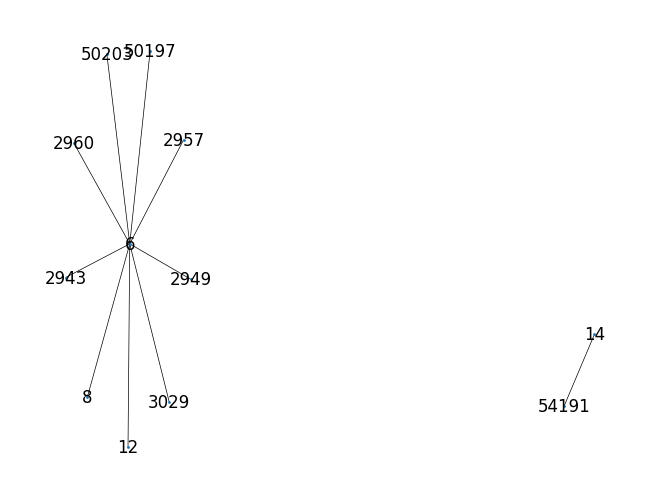

In [25]:
nx.draw(G, with_labels=True, font_weight='150', **graph_options)

### PRODUCT THREE:

In [26]:
def find_three_if_product(full_final_categorie_pairs, categorie):
    index = 1
    
    while categorie in full_final_categorie_pairs:
        print(f"{index}) {categorie} - {full_final_categorie_pairs[categorie][1]}")
        categorie = full_final_categorie_pairs[categorie][0]
        index += 1
    else:
        base_categorie = int(float(categorie))
    
        if base_categorie in full_base_categories:
            print(f"{index}) {base_categorie} - {full_base_categories[base_categorie]}")

In [27]:
find_three_if_product(full_final_categorie_pairs, 54191)

1) 54191 - Аптечные товары со скидкой
2) 14 - Аптека


### PARS ITEM NAMES:

In [28]:
def clear_item_name(item_name):
    answer_temporary = ""
    answer_final = ""
    
    for i in range(len(item_name) - 2):
        if item_name[i] == " " and item_name[i + 1] == "ш" and item_name[i + 2] == "т":
            answer_temporary = item_name[: i] + item_name[i + 3: ]
        elif item_name[i] == " " and item_name[i + 1] == "м" and item_name[i + 2] == "г":
            answer_temporary = item_name[: i] + item_name[i + 3: ]
        elif item_name[i] == " " and item_name[i + 1] == "м" and item_name[i + 2] == "л":
            answer_temporary = item_name[: i] + item_name[i + 3: ]
        
    if answer_temporary == "":
        answer_temporary = item_name

    for i in range(len(answer_temporary) - 1):
        if answer_temporary[i] == " " and answer_temporary[i + 1] == "г":
            answer_final = answer_temporary[: i] + answer_temporary[i + 2: ]
        elif answer_temporary[i] == " " and answer_temporary[i + 1] == "л":
            answer_final = answer_temporary[: i] + answer_temporary[i + 2: ]

    if answer_final == "":
        answer_final = answer_temporary
    
    return answer_final

In [29]:
def tokenize_item_name(item_name):
    answer = ""
    
    for symbol in item_name:
        if symbol == '_':
            answer += ' '
            continue  
        elif symbol in [
            '\\', 
            '(', 
            ')', 
            '.', 
            ',',
            '%'
        ] or symbol.isdigit():
            answer += ' '
            continue
        else:
            answer += symbol

    answer = clear_item_name(answer)

    while "  " in answer:
        answer = answer.replace("  ", " ")
        
    return answer

In [30]:
def find_number_in_string(string):
    answer = ""
    index = 0
    key = False
    
    for i in string:    
        if i >= '0' and i <= '9':
            key = True
            answer += i
        elif key:
            break

    return ("0" if answer == "" else answer.lower())

In [31]:
# Кривенько кидает числа
# Создать функции прогонки и чека конкретных слов с пробелами по типу шт г мл л

def find_tokens(catalog_df):
    names, weight, count, percents = pd.Series(), pd.Series(), pd.Series(), pd.Series()
    
    for i in range(len(catalog_df.index)):
        if '%' in catalog_df["item_name"][i]:
            percents = pd.concat([percents, pd.Series(find_number_in_string(catalog_df["item_name"][i]))], ignore_index=True)
        elif 'шт' in catalog_df["item_name"][i]:
             count = pd.concat([count, pd.Series(find_number_in_string(catalog_df["item_name"][i]))], ignore_index=True)
        elif 'г' in catalog_df["item_name"][i]:
            weight = pd.concat([weight, pd.Series(find_number_in_string(catalog_df["item_name"][i]))], ignore_index=True)
        else:
            weight = pd.concat([weight, pd.Series("0")], ignore_index=True)
            count = pd.concat([count, pd.Series("0")], ignore_index=True)
            percents = pd.concat([percents, pd.Series("0")], ignore_index=True)
    
        names = pd.concat([names, pd.Series(tokenize_item_name(catalog_df["item_name"][i]).lower())], ignore_index=True)
        
    return names, weight, count, percents

names, weight, count, percents = find_tokens(catalog_df)

prepare_catalog_df = pd.concat([catalog_df.item_name, names, weight, count, percents], axis=1, ignore_index=True)
prepare_catalog_df = prepare_catalog_df.rename(columns = {0: "item_name", 1: "clean_name", 2: "г", 3: "шт", 4: "%"})

In [32]:
prepare_catalog_df[0:10]

,item_name,clean_name,г,шт,%
0,Конфета жевательная с ароматом клубники,конфета жевательная с ароматом клубники,0,0,0
1,Смесь овощная \Три капусты\(Продукт замороженный),смесь овощная три капусты продукт замороженный,0,0,0
2,"Чипсы из морской капусты с анчоусами, 20 г",чипсы из морской капусты с анчоусами,20,0,0
3,Салат свекольный с грецким орехом,салат свекольный срецким орехом,0,0,0
4,"Кета малосоленая филе-ломтики, 150 г",кета малосоленая филе-ломтики,150,0,0
5,"Тунец холодного копчения карпаччо с кунжутом, ...",тунец холодного копчения карпаччо с кунжутом,100,0,0
6,Филе окорочка цыпленка-бройлера с овощами,филе окорочка цыпленка-бройлера с овощами,0,0,0
7,Нут жареный,нут жареный,0,0,5
8,Хлебцы ржаные с паприкой,хлебцы ржаные с паприкой,0,0,0
9,Пирожное \Ежик\,пирожное ежик,0,0,0
